In [164]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [165]:
df = pd.read_csv('processed/442100110323_daily.csv')
df

,READ_DATE,KWH_EXP
0,2019-01-01,1.704497
1,2019-01-02,1.804380
2,2019-01-03,1.606232
3,2019-01-04,1.220510
4,2019-01-05,0.980424
...,...,...
1973,2024-05-27,64.703542
1974,2024-05-28,63.751474
1975,2024-05-29,68.610622
1976,2024-05-30,65.846084


In [166]:
df_weather1 = pd.read_csv('processed/weather_2019_2024_standard.csv')

df_weather1.shape

(2008, 6)

In [167]:
df_weather1

,Unnamed: 0,Tanggal,Tavg,RH_avg,RR,ss
0,0,2019-01-01,25.7,96.0,12.9,7.5
1,1,2019-01-02,25.9,90.0,42.7,6.7
2,2,2019-01-03,24.9,94.0,0.5,0.1
3,3,2019-01-04,25.8,88.0,34.6,0.1
4,4,2019-01-05,26.7,88.0,2.1,3.2
...,...,...,...,...,...,...
2003,2003,2024-06-26,27.4,76.0,0.0,8.0
2004,2004,2024-06-27,27.8,77.0,0.0,9.9
2005,2005,2024-06-28,28.4,76.0,0.0,10.8
2006,2006,2024-06-29,28.6,65.0,0.0,10.0


In [168]:
df_weather1['Tanggal'] = pd.to_datetime(df_weather1['Tanggal'])
df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])

In [169]:
# gabung data weather dengan data daily
df_merge = pd.merge(df, df_weather1, left_on='READ_DATE', right_on='Tanggal', how='left')
df_merge.isna().sum()

READ_DATE       0
KWH_EXP         0
Unnamed: 0      0
Tanggal         0
Tavg            0
RH_avg          0
RR            131
ss              0
dtype: int64

In [170]:
df_merge.drop(columns=['Tanggal', 'Unnamed: 0'], inplace=True)
df_merge.interpolate(method='linear', inplace=True)
df_merge.isna().sum()

READ_DATE    0
KWH_EXP      0
Tavg         0
RH_avg       0
RR           0
ss           0
dtype: int64

In [ ]:
df_merge.to_csv('processed/442100110323_daily_weather_stdr.csv', index=False)

In [172]:
# ADF test
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_merge['KWH_EXP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -2.862144
p-value: 0.049931
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


p-value lebih besar dari 0.05 dan ADF Statistic lebih besar dari critical value pada tingkat signifikansi 5%. Ini berarti kita gagal menolak hipotesis nol, sehingga data kemungkinan besar tidak stasioner.

In [173]:
# KPSS test
from statsmodels.tsa.stattools import kpss

result = kpss(df_merge['KWH_EXP'])
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[3].items():
    print('\t%s: %.3f' % (key, value))


KPSS Statistic: 0.115071
p-value: 0.100000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


KPSS Statistic lebih besar dari critical value pada semua tingkat signifikansi, dan p-value lebih kecil dari 0.05. Ini berarti kita menolak hipotesis nol, sehingga data kemungkinan besar tidak stasioner.

ADF Test menunjukkan bahwa data tidak stasioner.
KPSS Test juga menunjukkan bahwa data tidak stasioner.

### FEATURE ENGINEERING BEFORE DIFFERENCING

In [174]:
lags = [1, 3, 7, 28] # 1 hari 3 hari 1 minggu 1 bulan
for lag in lags:
    df_merge['lag_{}'.format(lag)] = df_merge['KWH_EXP'].shift(lag)


In [175]:
window = [1, 3, 7, 28] # 1 hari 3 hari 1 minggu 1 bulan
for win in window:
    df_merge['rolling_mean_{}'.format(win)] = df['KWH_EXP'].rolling(window=win).mean()
    df_merge['rolling_std_{}'.format(win)] = df['KWH_EXP'].rolling(window=win).std()
    

In [176]:
# expanding window statistics
df_merge['expanding_mean'] = df_merge['KWH_EXP'].expanding().mean()
df_merge['expanding_std'] = df_merge['KWH_EXP'].expanding().std()
df_merge['expanding_max'] = df_merge['KWH_EXP'].expanding().max()
df_merge['expanding_min'] = df_merge['KWH_EXP'].expanding().min()
df_merge['expanding_sum'] = df_merge['KWH_EXP'].expanding().sum()
df_merge['expanding_median'] = df_merge['KWH_EXP'].expanding().median()
df_merge['expanding_skew'] = df_merge['KWH_EXP'].expanding().skew()
df_merge['expanding_kurt'] = df_merge['KWH_EXP'].expanding().kurt()
df_merge['expanding_quantile_25'] = df_merge['KWH_EXP'].expanding().quantile(0.25)
df_merge['expanding_quantile_75'] = df_merge['KWH_EXP'].expanding().quantile(0.75)

In [177]:
# Trend features daily average - avg
df_merge['daily_avg'] = df_merge['KWH_EXP'].rolling(window=1).mean()
df_merge['daily_avg'] = df_merge['daily_avg'].shift(1)

# Trend features 3 days average - avg
df_merge['3days_avg'] = df_merge['KWH_EXP'].rolling(window=3).mean()
df_merge['3days_avg'] = df_merge['3days_avg'].shift(1)

# Trend features weekly average - avg
df_merge['weekly_avg'] = df_merge['KWH_EXP'].rolling(window=7).mean()
df_merge['weekly_avg'] = df_merge['weekly_avg'].shift(1)

# Trend features monthly average - avg
df_merge['monthly_avg'] = df_merge['KWH_EXP'].rolling(window=28).mean()
df_merge['monthly_avg'] = df_merge['monthly_avg'].shift(1)


In [178]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   READ_DATE              1978 non-null   datetime64[ns]
 1   KWH_EXP                1978 non-null   float64       
 2   Tavg                   1978 non-null   float64       
 3   RH_avg                 1978 non-null   float64       
 4   RR                     1978 non-null   float64       
 5   ss                     1978 non-null   float64       
 6   lag_1                  1977 non-null   float64       
 7   lag_3                  1975 non-null   float64       
 8   lag_7                  1971 non-null   float64       
 9   lag_28                 1950 non-null   float64       
 10  rolling_mean_1         1978 non-null   float64       
 11  rolling_std_1          0 non-null      float64       
 12  rolling_mean_3         1976 non-null   float64       
 13  rol

In [179]:
df_merge.columns

Index(['READ_DATE', 'KWH_EXP', 'Tavg', 'RH_avg', 'RR', 'ss', 'lag_1', 'lag_3',
       'lag_7', 'lag_28', 'rolling_mean_1', 'rolling_std_1', 'rolling_mean_3',
       'rolling_std_3', 'rolling_mean_7', 'rolling_std_7', 'rolling_mean_28',
       'rolling_std_28', 'expanding_mean', 'expanding_std', 'expanding_max',
       'expanding_min', 'expanding_sum', 'expanding_median', 'expanding_skew',
       'expanding_kurt', 'expanding_quantile_25', 'expanding_quantile_75',
       'daily_avg', '3days_avg', 'weekly_avg', 'monthly_avg'],
      dtype='object')

In [180]:
df_merge.drop('rolling_std_1', inplace=True, axis=1)

In [ ]:
df_merge['READ_DATE'] = pd.to_datetime(df_merge['READ_DATE'])
df_merge.set_index('READ_DATE', inplace=True)

In [182]:
# Daily features
df_merge['day'] = df_merge.index.day
df_merge['month'] = df_merge.index.month
df_merge['quarter'] = df_merge.index.quarter
df_merge['year'] = df_merge.index.year
df_merge['dayofweek'] = df_merge.index.dayofweek
df_merge['dayofyear'] = df_merge.index.dayofyear
df_merge['weekofyear'] = df_merge.index.isocalendar().week
df_merge['is_month_start'] = df_merge.index.is_month_start
df_merge['is_month_end'] = df_merge.index.is_month_end
def determine_season(month):
    if month in [11, 12, 1, 2, 3]:
        return 0
    elif month in [4, 5, 6, 7, 8, 9, 10]:
        return 1
df_merge['season'] = df_merge['month'].apply(determine_season)
df_merge['is_weekend'] = df_merge['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
df_merge['is_weekday'] = df_merge['dayofweek'].apply(lambda x: 1 if x not in [5, 6] else 0)

In [183]:
# Cyclical Features
import numpy as np
df_merge['day_sin'] = np.sin(2 * np.pi * df_merge['day']/31)
df_merge['day_cos'] = np.cos(2 * np.pi * df_merge['day']/31)
df_merge['month_sin'] = np.sin(2 * np.pi * df_merge['month']/12)
df_merge['month_cos'] = np.cos(2 * np.pi * df_merge['month']/12)
df_merge['quarter_sin'] = np.sin(2 * np.pi * df_merge['quarter']/4)
df_merge['quarter_cos'] = np.cos(2 * np.pi * df_merge['quarter']/4)
df_merge['season_sin'] = np.sin(2 * np.pi * df_merge['season']/2)
df_merge['season_cos'] = np.cos(2 * np.pi * df_merge['season']/2)
df_merge['dayofweek_sin'] = np.sin(2 * np.pi * df_merge['dayofweek']/6)
df_merge['dayofweek_cos'] = np.cos(2 * np.pi * df_merge['dayofweek']/6)
df_merge['weekofyear_sin'] = np.sin(2 * np.pi * df_merge['weekofyear']/52)
df_merge['weekofyear_cos'] = np.cos(2 * np.pi * df_merge['weekofyear']/52)
df_merge['dayofyear_sin'] = np.sin(2 * np.pi * df_merge['dayofyear']/366)
df_merge['dayofyear_cos'] = np.cos(2 * np.pi * df_merge['dayofyear']/366)


In [184]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_merge['KWH_EXP'], model='additive', period=30) 
df_merge['trend'] = result.trend
df_merge['seasonal'] = result.seasonal
df_merge['residual'] = result.resid


In [185]:
df_merge['trend'].fillna(df_merge['trend'].median(), inplace=True)
df_merge['residual'].fillna(df_merge['residual'].mean(), inplace=True)
df_merge.fillna(0, inplace=True)

In [186]:
df_merge.isna().sum()

KWH_EXP                  0
Tavg                     0
RH_avg                   0
RR                       0
ss                       0
lag_1                    0
lag_3                    0
lag_7                    0
lag_28                   0
rolling_mean_1           0
rolling_mean_3           0
rolling_std_3            0
rolling_mean_7           0
rolling_std_7            0
rolling_mean_28          0
rolling_std_28           0
expanding_mean           0
expanding_std            0
expanding_max            0
expanding_min            0
expanding_sum            0
expanding_median         0
expanding_skew           0
expanding_kurt           0
expanding_quantile_25    0
expanding_quantile_75    0
daily_avg                0
3days_avg                0
weekly_avg               0
monthly_avg              0
day                      0
month                    0
quarter                  0
year                     0
dayofweek                0
dayofyear                0
weekofyear               0
i

In [187]:
df_merge.to_csv('processed/442100110323_daily_weather_temp.csv')

### FEATURE ENGINEERING AFTER DIFFERENCING

<Axes: >

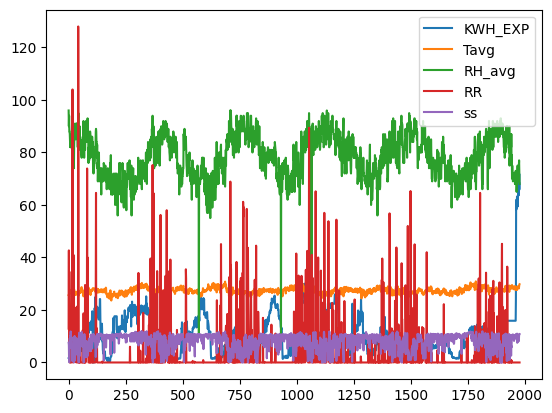

In [204]:
df_merge = pd.read_csv('processed/442100110323_daily_weather_stdr.csv')
df_merge.plot()

<Axes: >

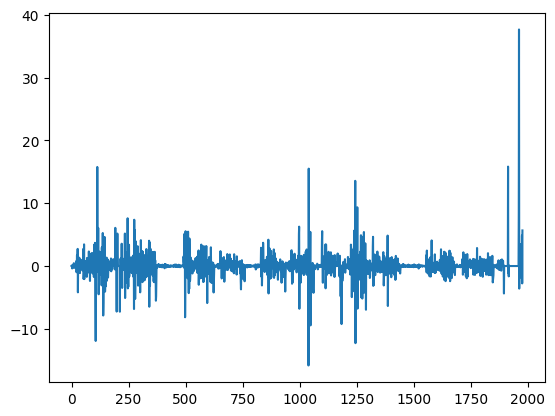

In [205]:
# differencing
df_merge['KWH_EXP'] = df_merge['KWH_EXP'].diff()
df_merge['KWH_EXP'].fillna(df_merge['KWH_EXP'].mean(), inplace=True)
df_merge['KWH_EXP'].plot()

In [206]:
lags = [1, 3, 7, 28] # 1 hari 3 hari 1 minggu 1 bulan
for lag in lags:
    df_merge['lag_{}'.format(lag)] = df_merge['KWH_EXP'].shift(lag)


In [207]:
window = [1, 3, 7, 28] # 1 hari 3 hari 1 minggu 1 bulan
for win in window:
    df_merge['rolling_mean_{}'.format(win)] = df['KWH_EXP'].rolling(window=win).mean()
    df_merge['rolling_std_{}'.format(win)] = df['KWH_EXP'].rolling(window=win).std()
    

In [208]:
# expanding window statistics
df_merge['expanding_mean'] = df_merge['KWH_EXP'].expanding().mean()
df_merge['expanding_std'] = df_merge['KWH_EXP'].expanding().std()
df_merge['expanding_max'] = df_merge['KWH_EXP'].expanding().max()
df_merge['expanding_min'] = df_merge['KWH_EXP'].expanding().min()
df_merge['expanding_sum'] = df_merge['KWH_EXP'].expanding().sum()
df_merge['expanding_median'] = df_merge['KWH_EXP'].expanding().median()
df_merge['expanding_skew'] = df_merge['KWH_EXP'].expanding().skew()
df_merge['expanding_kurt'] = df_merge['KWH_EXP'].expanding().kurt()
df_merge['expanding_quantile_25'] = df_merge['KWH_EXP'].expanding().quantile(0.25)
df_merge['expanding_quantile_75'] = df_merge['KWH_EXP'].expanding().quantile(0.75)

In [209]:
# Trend features daily average - avg
df_merge['daily_avg'] = df_merge['KWH_EXP'].rolling(window=1).mean()
df_merge['daily_avg'] = df_merge['daily_avg'].shift(1)

# Trend features 3 days average - avg
df_merge['3days_avg'] = df_merge['KWH_EXP'].rolling(window=3).mean()
df_merge['3days_avg'] = df_merge['3days_avg'].shift(1)

# Trend features weekly average - avg
df_merge['weekly_avg'] = df_merge['KWH_EXP'].rolling(window=7).mean()
df_merge['weekly_avg'] = df_merge['weekly_avg'].shift(1)

# Trend features monthly average - avg
df_merge['monthly_avg'] = df_merge['KWH_EXP'].rolling(window=28).mean()
df_merge['monthly_avg'] = df_merge['monthly_avg'].shift(1)


In [210]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1978 entries, 0 to 1977
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   READ_DATE              1978 non-null   object 
 1   KWH_EXP                1978 non-null   float64
 2   Tavg                   1978 non-null   float64
 3   RH_avg                 1978 non-null   float64
 4   RR                     1978 non-null   float64
 5   ss                     1978 non-null   float64
 6   lag_1                  1977 non-null   float64
 7   lag_3                  1975 non-null   float64
 8   lag_7                  1971 non-null   float64
 9   lag_28                 1950 non-null   float64
 10  rolling_mean_1         1978 non-null   float64
 11  rolling_std_1          0 non-null      float64
 12  rolling_mean_3         1976 non-null   float64
 13  rolling_std_3          1976 non-null   float64
 14  rolling_mean_7         1972 non-null   float64
 15  roll

In [211]:
df_merge.drop('rolling_std_1', inplace=True, axis=1)

In [212]:
df_merge['READ_DATE'] = pd.to_datetime(df_merge['READ_DATE'])
df_merge.set_index('READ_DATE', inplace=True)

In [213]:
# Daily features
df_merge['day'] = df_merge.index.day
df_merge['month'] = df_merge.index.month
df_merge['quarter'] = df_merge.index.quarter
df_merge['year'] = df_merge.index.year
df_merge['dayofweek'] = df_merge.index.dayofweek
df_merge['dayofyear'] = df_merge.index.dayofyear
df_merge['weekofyear'] = df_merge.index.isocalendar().week
df_merge['is_month_start'] = df_merge.index.is_month_start
df_merge['is_month_end'] = df_merge.index.is_month_end
def determine_season(month):
    if month in [11, 12, 1, 2, 3]:
        return 0
    elif month in [4, 5, 6, 7, 8, 9, 10]:
        return 1
df_merge['season'] = df_merge['month'].apply(determine_season)
df_merge['is_weekend'] = df_merge['dayofweek'].apply(lambda x: 1 if x in [5, 6] else 0)
df_merge['is_weekday'] = df_merge['dayofweek'].apply(lambda x: 1 if x not in [5, 6] else 0)

In [214]:
# Cyclical Features
import numpy as np
df_merge['day_sin'] = np.sin(2 * np.pi * df_merge['day']/31)
df_merge['day_cos'] = np.cos(2 * np.pi * df_merge['day']/31)
df_merge['month_sin'] = np.sin(2 * np.pi * df_merge['month']/12)
df_merge['month_cos'] = np.cos(2 * np.pi * df_merge['month']/12)
df_merge['quarter_sin'] = np.sin(2 * np.pi * df_merge['quarter']/4)
df_merge['quarter_cos'] = np.cos(2 * np.pi * df_merge['quarter']/4)
df_merge['season_sin'] = np.sin(2 * np.pi * df_merge['season']/2)
df_merge['season_cos'] = np.cos(2 * np.pi * df_merge['season']/2)
df_merge['dayofweek_sin'] = np.sin(2 * np.pi * df_merge['dayofweek']/6)
df_merge['dayofweek_cos'] = np.cos(2 * np.pi * df_merge['dayofweek']/6)
df_merge['weekofyear_sin'] = np.sin(2 * np.pi * df_merge['weekofyear']/52)
df_merge['weekofyear_cos'] = np.cos(2 * np.pi * df_merge['weekofyear']/52)
df_merge['dayofyear_sin'] = np.sin(2 * np.pi * df_merge['dayofyear']/366)
df_merge['dayofyear_cos'] = np.cos(2 * np.pi * df_merge['dayofyear']/366)


In [215]:
# decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_merge['KWH_EXP'], model='additive', period=30) 
df_merge['trend'] = result.trend
df_merge['seasonal'] = result.seasonal
df_merge['residual'] = result.resid


In [216]:
df_merge['trend'].fillna(df_merge['trend'].median(), inplace=True)
df_merge['residual'].fillna(df_merge['residual'].mean(), inplace=True)
df_merge.fillna(0, inplace=True)

In [217]:
df_merge.isna().sum()

KWH_EXP                  0
Tavg                     0
RH_avg                   0
RR                       0
ss                       0
lag_1                    0
lag_3                    0
lag_7                    0
lag_28                   0
rolling_mean_1           0
rolling_mean_3           0
rolling_std_3            0
rolling_mean_7           0
rolling_std_7            0
rolling_mean_28          0
rolling_std_28           0
expanding_mean           0
expanding_std            0
expanding_max            0
expanding_min            0
expanding_sum            0
expanding_median         0
expanding_skew           0
expanding_kurt           0
expanding_quantile_25    0
expanding_quantile_75    0
daily_avg                0
3days_avg                0
weekly_avg               0
monthly_avg              0
day                      0
month                    0
quarter                  0
year                     0
dayofweek                0
dayofyear                0
weekofyear               0
i

In [218]:
df_merge.to_csv('processed/442100110323_daily_weather_stationary_temp.csv')